In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.interpolate import griddata as gd
from pykrige.ok import OrdinaryKriging
from matplotlib import cm
import netCDF4 as nc
import scipy.io
import glob,csv
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
%matplotlib inline

#Th_diss Interpolation (layer 21)

In [11]:
data=scipy.io.loadmat('/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Th_diss.mat')
NEMO_dep=data['NEMO_dep']
Pa_diss=data['Th_diss']
lons=data['lons']
lats=data['lats']

In [12]:
layer=21
x=lons[layer,:]
y=lats[layer,:]
z=Pa_diss[layer,:]
x_ma=np.ma.masked_where(abs(x)<= 1e-200,x)
x_ma=np.ma.masked_where(np.isnan(x_ma),x_ma)
y_ma=np.ma.masked_where(abs(x)<= 1e-200,y)
y_ma=np.ma.masked_where(np.isnan(y_ma),y_ma)
z_ma=np.ma.masked_where(abs(z)<= 1e-200,z)
z_ma=np.ma.masked_where(np.isnan(y_ma),z_ma)

In [13]:
coordinate_name=glob.glob('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/test/EXP00/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [14]:
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
x_dis,y_dis = m(x_ma, y_ma)
x_lon,y_lat = m(nav_lon, nav_lat)
a,b=m(90,90)
#print a
#print b

In [15]:
xx_lon=np.empty([149,182])
yy_lat=np.empty([149,182])
xx_dis=np.empty([len(x_dis)])
yy_dis=np.empty([len(x_dis)])

for j in range (182):
    for i in range (149):
        xx_lon[i,j]=x_lon[i,j]-a
        yy_lat[i,j]=y_lat[i,j]-b
        
xx_lon_ma=np.ma.masked_where(nav_lat<55,xx_lon)
yy_lat_ma=np.ma.masked_where(nav_lat<55,yy_lat)


for k in range (len(xx_dis)):
        xx_dis[k]=x_dis[k]-a
        yy_dis[k]=y_dis[k]-b        
xx_dis=np.ma.masked_where(np.isnan(xx_dis),xx_dis)
yy_dis=np.ma.masked_where(np.isnan(yy_dis),yy_dis)
z_ma=np.ma.masked_where(np.isnan(yy_dis),z_ma)

xxx_dis=xx_dis.compressed()
yyy_dis=yy_dis.compressed()
zzz_ma=z_ma.compressed()
#print xxx_dis
#print yyy_dis
#spherical
#gaussian

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: -3.36868966973e-23
Nugget: 0.0263127627204 



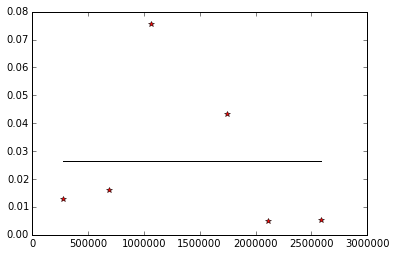

Calculating statistics on variogram model fit...
Q1 = 0.300402519949
Q2 = 0.833708528958
cR = 0.0283329506358 

Executing Ordinary Kriging...



In [16]:
OK = OrdinaryKriging(xxx_dis,yyy_dis, zzz_ma, variogram_model='linear', verbose=True, enable_plotting=True)
Pa_interp, ss = OK.execute('points',xx_lon, yy_lat)
Pa_interp=Pa_interp.reshape(149,182)

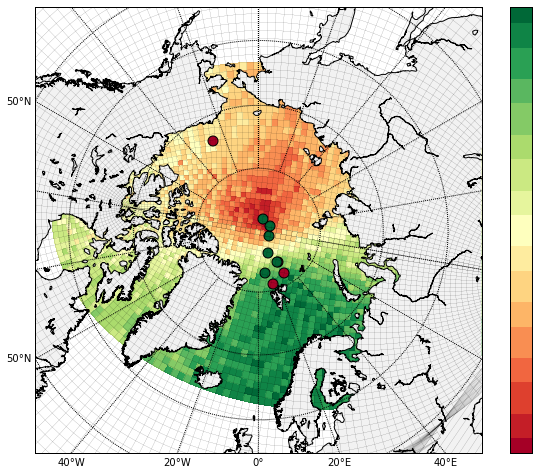

In [20]:
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x,y = m(nav_lon, nav_lat)
plt.plot(x,y,x.T,y.T,color='k',linewidth=0.1)
CS = m.pcolor(x[120:-1,:],y[120:-1,:],Pa_interp[120:-1,:],cmap=plt.cm.RdYlGn)
CBar = plt.colorbar(CS, shrink=0.8)
#plt.clim(np.min(Pa_interp),np.max(Pa_interp))
#m.scatter(x[0,90],y[0,90],color='yellow',s=100)
x_maa=x_ma.compressed()
y_maa=y_ma.compressed()
z_maa=z_ma.compressed()
for j in range(len(x_maa)):
    x2,y2= m(x_maa[j], y_maa[j])
    cmm = plt.cm.get_cmap('RdYlGn')
    #m.scatter(x2,y2,c=z_maa[j],vmin=np.min(z_maa),vmax=np.max(z_maa),cmap=cmm,s=100)
    m.scatter(x2,y2,c=z_maa[j],vmin=np.min(Pa_interp),vmax=np.max(Pa_interp),cmap=cmm,s=100)
plt.show()

###compare zzz_ma(original data) with the interp.

In [18]:
print zzz_ma.max()
print zzz_ma.min()
print zzz_ma

0.69933746543
0.190897837741
[ 0.3880139   0.34343793  0.22388375  0.19089784  0.29497533  0.40268231
  0.392       0.69933747  0.43361987  0.4153586 ]


In [19]:
print Pa_interp.max()
print Pa_interp.min()

0.378420698748
0.378420698748
